In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import jit, lax, vmap, jacobian
import jax.scipy.linalg as jsl

import jax

import numpy as np
from read_traj_v2 import *

import scipy.optimize

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# !pip3 install torch torchvision torchaudio

In [3]:
import torch
import torch.nn as nn

In [4]:
mol = 'heh+'
basis = 'sto-3g'
init = 'hf'
td = 'rt-tdexx'

dt = 0.08268/10

inpath = './correctdata'
inpath2 = './mydata/'
outpath = './'
saved_model_dir = './models/'

trnfrq = jnp.array(np.load('./tdcis_data/tdcis_trnfreq_dt0.008268.npz'))
trnamp = jnp.array(np.load('./tdcis_data/tdcis_trnamp_dt0.008268.npz'))
trntme = jnp.array(np.load('./tdcis_data/tdcis_trntme_dt0.008268.npz'))
# load important static matrices
a = traj_data(inpath, mol, basis, init, td, '001',
                init_cond_file=f'ke+en+overlap+ee_twoe+dip_casscf22_{mol}_{basis}.npz',
                )
a.assign_init_data()
drc = a.drc
xmat, didat, kinmat, enmat = a.xmat, a.didat, a.kinmat, a.enmat
X = xmat


	reading from "./correctdata/ke+en+overlap+ee_twoe+dip_casscf22_heh+_sto-3g.npz"

can only concatenate str (not "NoneType") to str
True is not in list


In [5]:
trnden = np.array(np.load('./tdcis_data/tdcis_dt0.0082680.npz'))
print(trnden.shape)

(301, 10000, 2, 2)


In [6]:
trntimecoeffs = np.array(np.load('./tdcis_data/time_coeffs_tdcis_dt0.008268.npz'))
print(trntimecoeffs.shape)

(300, 10000, 2)


In [7]:
torch.set_default_dtype(torch.float64)
input_size = 16
output_size = 4
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()                    
        # layer 1
        self.fc1 = nn.Linear(input_size, 256) 
        self.batch1 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(0.25)

        # layer 2
        self.fc2 = nn.Linear(256, 256)
        self.batch2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.25)

        # layer 3
        self.fc3 = nn.Linear(256, 256)
        self.batch3 = nn.BatchNorm1d(256)
        self.drop3 = nn.Dropout(0.25)

        # layer 4
        self.fc4 = nn.Linear(256, 256)
        self.batch4 = nn.BatchNorm1d(256)
        self.drop4 = nn.Dropout(0.25)

        self.fc5 = nn.Linear(256, output_size)
        
        self.selu = nn.SELU() 
        self.sm = nn.Softmax(dim=1)
    def forward(self, x):                            

        # layer 1
        out = self.fc1(x)
        out = self.batch1(out)
        out = self.selu(out)
        #out = self.drop1(out)

        # layer 2
        out = self.fc2(out)
        out = self.batch2(out)
        out = self.selu(out)
        #out = self.drop2(out)

        # layer 3
        out = self.fc3(out)
        out = self.batch3(out)
        out = self.selu(out)
        #out = self.drop3(out)

        # layer 4
        out = self.fc4(out)
        out = self.batch4(out)
        out = self.selu(out)
        #out = self.drop4(out)

        out = self.fc5(out)
        #out = self.sm(out)
        return out


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print('using gpu')

using gpu


In [9]:
#TODO split into real and imaginary parts
traj = 145
X = trnden[145].reshape((10000,4))
y = trntimecoeffs[145]
X.shape, y.shape

((10000, 4), (10000, 2))

In [10]:
X

array([[0.10477089+0.00000000e+00j, 0.30625791+0.00000000e+00j,
        0.30625791+0.00000000e+00j, 0.89522938+0.00000000e+00j],
       [0.10477089+0.00000000e+00j, 0.30625791+0.00000000e+00j,
        0.30625791+0.00000000e+00j, 0.89522938+0.00000000e+00j],
       [0.10477094-2.13773805e-22j, 0.30625798-1.90978275e-05j,
        0.30625798+1.90978275e-05j, 0.89522933+1.67210403e-22j],
       ...,
       [0.38503679-5.43656889e-18j, 0.13976733-3.35538405e-01j,
        0.13976733+3.35538405e-01j, 0.61496328-5.35747230e-18j],
       [0.38689461-4.56209950e-18j, 0.14216486-3.35162331e-01j,
        0.14216486+3.35162331e-01j, 0.61310545-1.56684383e-17j],
       [0.38875026+6.38544073e-18j, 0.1445596 -3.34758839e-01j,
        0.1445596 +3.34758839e-01j, 0.61124978+9.64929512e-18j]])

In [11]:
centered_X = X-np.mean(X)
sclfac = np.max(np.abs(centered_X))
print(sclfac)
#X = centered_X/sclfac
X = X - np.min(X)/(np.max(X)-np.min(X))

0.5879268432614047


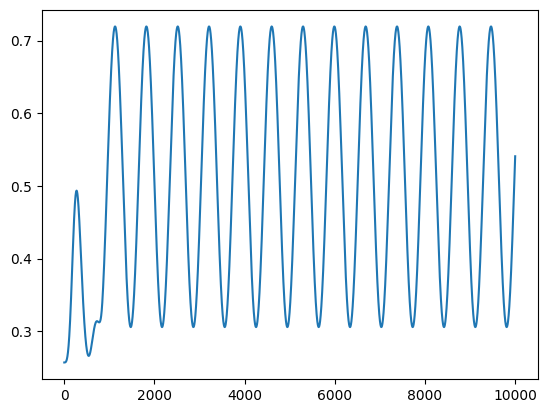

In [12]:
plt.plot(X[:,0].real)

In [13]:
newX = np.zeros((X.shape[0], 16))
for i in range(0,3):
    newX[i] = np.append(np.array([X[i][0].real, X[i][1].real, X[i][1].imag, X[i][3].real]), np.zeros(12))
for i in range(3, X.shape[0]):
    newX[i] = np.array([X[i][0].real, X[i][1].real, X[i][1].imag, X[i][3].real,
                       X[i-1][0].real, X[i-1][1].real, X[i-1][1].imag, X[i-1][3].real,
                       X[i-2][0].real, X[i-2][1].real, X[i-2][1].imag, X[i-2][3].real,
                       X[i-3][0].real, X[i-3][1].real, X[i-3][1].imag, X[i-3][3].real])

In [14]:
newy = np.zeros((y.shape[0],4))
for i in range(y.shape[0]):
    newy[i] = np.array([y[i][0].real, y[i][0].imag, y[i][1].real, y[i][1].imag])

In [15]:
X = newX
y = newy

In [16]:
# from sklearn.model_selection import train_test_split
# train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.10, random_state=57109, shuffle=True)

In [17]:
train_datat = torch.from_numpy(X)
train_labelst = torch.from_numpy(y)

In [18]:
net = Net(input_size, output_size)
net = net.to(device)

In [19]:
train_datat = train_datat.to(device)
train_labelst = train_labelst.to(device)

In [20]:
from torch.nn.functional import mse_loss
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = ExponentialLR(optimizer, gamma=0.95)
scheduler = ReduceLROnPlateau(optimizer, 'min')

In [21]:
num_epochs = 50000
batch_size = 10000
losses = []
for epoch in range(1, num_epochs + 1):
    final_loss = 0
    for i in range(0, train_datat.shape[0], batch_size):
        optimizer.zero_grad()
        if i + batch_size > train_datat.shape[0]:
            batched_data = train_datat[i:]
        else:
            batched_data = train_datat[i: i + batch_size]
        outputs = net(batched_data)
        loss =  mse_loss(outputs, train_labelst[i: i + batch_size])
        loss.backward()
        optimizer.step()
        #scheduler.step(loss)
    losses.append(loss.item()) 
    if epoch % 100 == 0:
        print('Epoch: {}/{}.............'.format(epoch, num_epochs), end=' ')
        print("Loss: ", loss.item())

Epoch: 100/50000............. Loss:  0.005432339378200113
Epoch: 200/50000............. Loss:  0.003912300736861572
Epoch: 300/50000............. Loss:  0.00267735283230708
Epoch: 400/50000............. Loss:  0.007345905329290213
Epoch: 500/50000............. Loss:  0.000558916629253537
Epoch: 600/50000............. Loss:  0.0002892045133218517
Epoch: 700/50000............. Loss:  0.00017627610227752806
Epoch: 800/50000............. Loss:  0.0003299675574348072
Epoch: 900/50000............. Loss:  0.0010638742042781743
Epoch: 1000/50000............. Loss:  4.373739603402225e-05
Epoch: 1100/50000............. Loss:  3.664542596438417e-05
Epoch: 1200/50000............. Loss:  2.007233470353504e-05
Epoch: 1300/50000............. Loss:  3.363365564212193e-05
Epoch: 1400/50000............. Loss:  1.1721611587323469e-05
Epoch: 1500/50000............. Loss:  0.00025524680223390814
Epoch: 1600/50000............. Loss:  1.1949309818696133e-05
Epoch: 1700/50000............. Loss:  7.72912608622

In [22]:
pred = net(torch.from_numpy(newX).to(device))
pred

tensor([[ 9.9949e-01, -1.8357e-04,  5.2144e-04,  3.0387e-04],
        [ 9.9949e-01, -1.8357e-04,  5.2144e-04,  3.0387e-04],
        [ 9.9949e-01, -1.8152e-04,  5.2844e-04,  2.9695e-04],
        ...,
        [ 3.4639e-01,  4.8281e-01,  5.8436e-01, -5.5311e-01],
        [ 3.4637e-01,  4.8280e-01,  5.7934e-01, -5.5838e-01],
        [ 3.4635e-01,  4.8280e-01,  5.7425e-01, -5.6359e-01]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [23]:
print(np.allclose([np.sum(np.abs(pred[i,:].cpu().detach().numpy())**2) for i in range(pred.shape[0])], 1.0, 1e-2))

True


In [31]:
print(np.allclose([np.sum(np.abs(newy[i,:])**2) for i in range(newy.shape[0])], 1.0, 1e-8))

True


In [24]:
newy

array([[ 1.0000000e+00,  3.4220000e-05, -1.2000000e-07, -2.7010000e-05],
       [ 9.9999999e-01,  1.0267000e-04, -6.1000000e-07, -8.1020000e-05],
       [ 9.9999997e-01,  2.0534000e-04, -1.6900000e-06, -1.6203000e-04],
       ...,
       [ 3.4605000e-01,  4.8292447e-01,  5.8377250e-01, -5.5339229e-01],
       [ 3.4605000e-01,  4.8292447e-01,  5.7874353e-01, -5.5864951e-01],
       [ 3.4605000e-01,  4.8292447e-01,  5.7366722e-01, -5.6386104e-01]])

In [32]:
x = net(torch.from_numpy(newX).to(device)).cpu()
y = newy
np.linalg.norm((x.detach().numpy()-y))

0.12075661989543802